In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano

sns.set()
plt.ion()

# Functions and Classes

In [258]:
def compare(model_dict, model_names):
    """
    Compare models on WAIC (and some other measures)
    
    model_dict: {pymc_model: pymc_model_trace}
    model_names: iterable of strings, order of names must correspond to order of models in model_dict
    """
    
    # var needs to be Series b/c 'pm.compare' returns dataframe which is sorted
    # by IC. need to match model names to entries of that dataframe by index,
    # which indicates initial position of the model when given to this function
    # note: silly design by pymc3
    model_names = pd.Series(model_names)
    
    return (
        pm
        .compare(
            model_dict = model_dict,
            method = 'BB-pseudo-BMA'
        )
        .assign(model =  model_names)
        .set_index('model')
        .sort_values('WAIC')
    )

In [255]:
# Code 7.2

def create_rugged_log_gdp_model(dataset, return_dataframe=True):
    """
    model log_gdp as a linear function of ruggedness using data from `dataset`
    """
    with pm.Model() as model:
        sigma = pm.Uniform('sigma', 0, 10)
        bR = pm.Normal('bR', 0, 1)
        a = pm.Normal('a', 8, 100)
        mu = pm.Deterministic('mu', a + bR * dataset.rugged)
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

        trace = pm.sample(1000, tune=1000, progressbar=False)
        
        if return_dataframe:
            trace = pm.trace_to_dataframe(trace)
        
    return model, trace

In [289]:
def attach_mu_predictions_to_data(xy_data, trace_df):
    """
    For source data and a trace of posterior samples: calculate sample mean and hpd boundaries,
    attach them to the original data into one joined dataframe.
    
    Assume that 'mu__n' column of samples belongs to n-th data point in dataframe.
    
    In:
        xy_data: dataframe
        trace_df: dataframe having columns with name pattern 'mu__x'
        
    Out:
        'xy_data' dataframe with new columns 'mu_means', 'mu_hpd_lower', and 'mu_hpd_upper'
    """
    
    mu_samples = trace_df.filter(like='mu__')
    mu_means = mu_samples.mean(axis=0)

    mu_hpd_lower, mu_hpd_upper = np.split(
        ary=pm.hpd(mu_samples.values, alpha=0.03),
        indices_or_sections=2,
        axis=1
    )

    return (
        xy_data
        .assign(
            mu_means = mu_means.values,
            mu_hpd_upper = mu_hpd_upper,
            mu_hpd_lower = mu_hpd_lower
        )
    )

In [301]:
def create_plot_scatter_with_predicted_means(xy_data, trace_df, x, y, ax = None, plot_y = True):
    """
    Make predictions from samples, attach them to original data and plot original data and
    predictions together
    
    In:
        xy_data: dataframe with columns 'x' and 'y'
        trace_df: dataframe with posterior samples
        x: string col name
        y: string col name
        ax: what axes to plot into
    
    Out:
        ax: axes with plot
    """
    
    # calculate sample summaries and attach to original data
    # sort by x for plotting line of predicted mu values
    d_with_preds = attach_mu_predictions_to_data(xy_data, trace_df).sort_values(x)

    if ax is None:
        ax = plt.axes()

    ax.plot(x, 'mu_means', 'g-', data=d_with_preds)
    ax.fill_between(x, 'mu_hpd_lower', 'mu_hpd_upper', color='g', alpha=.3, data=d_with_preds)
    
    if plot_y:
        ax.plot(x, y, 'ob', mew=1, fillstyle='none', alpha=.3, data=d_with_preds)
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    return ax

In [375]:
class FittedModel(object):
    """
    Container to hold pymc3 model together with its mcmc trace and theano shared variables for prediction
    """
    
    def __init__(self, model, trace, predictor_dict, name):
        """
        model: pymc3 model
        trace: pymc3 trace for model
        predictor_dict = {'predictor_n': theano_tensor_n}
        """
        self.model = model
        self.trace = trace
        self.predictor_dict = predictor_dict
        self.name = name
        
    def _repr_latex_(self):
        return self.model._repr_latex_()
    
    
    def sample_mu(self, predictor_values):
        """
        Generate samples of 'mu' variable based on 'predictor_values' (yes, this is basically
        the 'link' function, just as a method).
        
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with samples for means, one column per input data point
        """

        for predictor_name in predictor_values.columns:
            predictor_shared_var = self.predictor_dict[predictor_name]
            predictor_shared_var.set_value(predictor_values[predictor_name].values)

        samples = pm.sample_ppc(
            trace=self.trace, 
            model=self.model, 
            vars=[self.model.mu],
            progressbar=False
        )

        mu_samples = samples['mu']

        columns = ['mu__{}'.format(i) for i in range(mu_samples.shape[1])]

        return pd.DataFrame(data=mu_samples, columns=columns)
    
    def predict_mu(self, predictor_values):
        """
        Generate mean/hpd predictions for mu based on 'predictor_values'. Closest to model.predic()
        in sklearn
        
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with mean and hpd of estimated mus, each row matches one input row of predictor_values df
        """
        
        mu_samples = samples.filter(like='mu__')

        mu_means = mu_samples.mean(axis=0)

        mu_hpd_lower, mu_hpd_upper = np.split(
            ary=pm.hpd(mu_samples.values, alpha=0.03),
            indices_or_sections=2,
            axis=1
        )

        # 'squeeze()' necessary to remove empty 2nd axis, pandas complains otherwise
        return pd.DataFrame(
            {
                'mu_means': mu_means, 
                'mu_hpd_lower': mu_hpd_lower.squeeze(), 
                'mu_hpd_upper': mu_hpd_upper.squeeze()
            }
        )

In [260]:
def link(fitted_model, predictor_values):
    """
    Generate samples of 'mu' variable for 'fitted_model' based on 'predictor_values'
    
    Note: updates theano shared variables for this model. this will affect *all* usages of this
    model made afterwards :(
    
    In:
        fitted_model: FittedModel instance
        predictor_values: DataFrame with column names matching fitted_model.predictor_dict.keys()
        
    Out:
        df with samples for means, one column per input data point
    """
    
    for predictor_name in predictor_values.columns:
        predictor_shared_var = fitted_model.predictor_dict[predictor_name]
        predictor_shared_var.set_value(predictor_values[predictor_name].values)

    samples = pm.sample_ppc(
        trace=fitted_model.trace, 
        model=fitted_model.model, 
        vars=[fitted_model.model.mu],
        progressbar=False
    )

    mu_samples = samples['mu']

    columns = ['mu__{}'.format(i) for i in range(mu_samples.shape[1])]

    return pd.DataFrame(data=mu_samples, columns=columns)

# 7 Interactions

Conditioning: data conditional on how we get our samples. Posterior distributions conditional on data. All inference conditional on the model. Every inference is conditional, but we might not realize it.

Lin model = way of seeing outcome as conditional on predictors of that case.

Lin model assumes each predictor has independent association w/ mean of outcome **how does this work if interpretation of coefficient is "amount information gained when learning about this variable, already knowing all others"? probably doesn't work. need more basic interpretation. maybe "coefficent = expected change in outcome mean for unit increase in predictor, while keeping other predictors constant". still linked somehow?**

Ex: assume that link between brain size and milk energy depends on what kind of primate we are looking at (ape, monkey, prosimian). Influence needs to be conditional on that. McElreath: Lin. model in previous chapters cannot capture this. **again seems to indicate that we cannot use interpretation of 'given all other factors, how much do we learn about milk energy by getting information about brain size'. because 'all other factors' would include 'kind of primate'. which is weird, because is this not what 'statistically controlling for' would imply? we put in the another predictor into the model and thus control for it. more questions, not more answers. need discussion.**

want to model: importance of predictor A depends on predictor B. need: interaction. simplest one: linear interaction. see below.

## 7.1. Building an interaction

In [12]:
# Code 7.1

d = pd.read_csv('./data/rugged.csv', sep=';').set_index('isocode')

# make log version of outcome
d = d.assign(log_gdp=np.log(d.rgdppc_2000))

# drop incomplete cases
dd = d.dropna(subset=['rgdppc_2000'])

# split countries into africa and not-africa
d_a1 = dd.query('cont_africa == 1')
d_a0 = dd.query('cont_africa == 0')

In [25]:
# african countries
m_7_1, trace_7_1 = create_rugged_log_gdp_model(d_a1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1105.99draws/s]


In [26]:
# non-african countries
m_7_2, trace_7_2 = create_rugged_log_gdp_model(d_a0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1156.51draws/s]


Text(0.5, 1.0, 'Non-African countries')

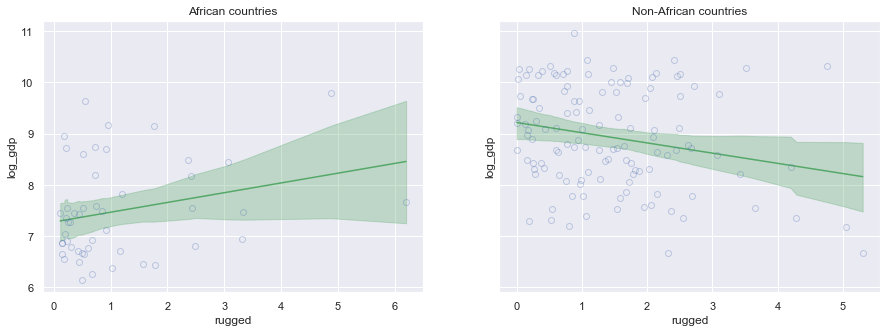

In [308]:
x = 'rugged'
y = 'log_gdp'

fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_a1, trace_7_1, x, y, axes_array[0])
ax.set_title('African countries')

ax = create_plot_scatter_with_predicted_means(d_a0, trace_7_2, x, y, axes_array[1])
ax.set_title('Non-African countries')

Slope different, but bad idea to split data into two frames like this because:

* now assumes variance (sigma) is different between african and non-african countries
* can't make statements about predictive power/uncertainty of 'is_african' variable used to split data
* can't use information criteria to compare models b/c fitted on different data
* can't use information from non-african countries for african countries/vice versa, which is done in multilevel models

Instead, create one model that allows different slope based on predictor values

### 7.1.1. adding a dummy variable doesn't work

In [376]:
# Code 7.3

m, t = create_rugged_log_gdp_model(dd, return_dataframe=False)

fit_m_7_3 = FittedModel(m, t, None, 'm_7_3')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


In [378]:
# Code 7.4

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)


# object for easier bookkeeping
fit_m_7_4 = FittedModel(
    model = model,
    trace = trace,
    predictor_dict = {
        'rugged': rugged,
        'cont_africa': cont_africa
    },
    name = 'm_7_4'
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]


In [353]:
# Code 7.5
compare(
    model_dict = {
        fit_m_7_3.model: fit_m_7_3.trace,
        fit_m_7_4.model: fit_m_7_4.trace
    },
    model_names = ['m_7_3', 'm_7_4']
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_4,475.8,3.94,0,1,14.32,0,1
m_7_3,539.49,2.6,63.7,0,12.7,14.46,0


Text(0.5, 1.0, 'African countries')

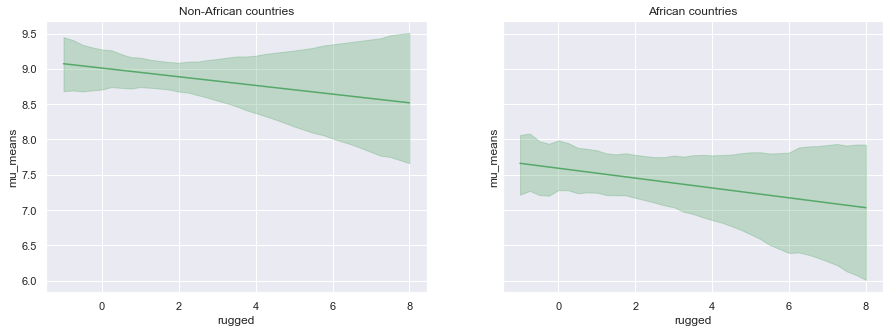

In [334]:
# Code 7.6

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create posterior samples of mu for predictor values
mu_not_africa = link(fit_m_7_4, d_not_africa)
mu_africa = link(fit_m_7_4, d_africa)

# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

No difference whatsoever in slope, perfectly parallel, just shifted. Can't change slope by including dummy variable. Model is only better in terms of WAIC b/c it allows model to capture fact that African nations on average have lower GDP

### 7.1.2. Adding a linear interaction does work

In [379]:
# Code 7.7

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    gamma = pm.Deterministic('gamma', bR + bAR * cont_africa)
    mu = pm.Deterministic('mu', a + gamma * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

fit_m_7_5 = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa}, 'm_7_5')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


In [355]:
# Code 7.8

compare(
    model_dict = {
        fit_m_7_3.model: fit_m_7_3.trace,
        fit_m_7_4.model: fit_m_7_4.trace,
        fit_m_7_5.model: fit_m_7_5.trace
    },
    model_names = ['m_7_3', 'm_7_4', 'm_7_5']
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_5,469.36,5.02,0,0.83,13.88,0,1
m_7_4,475.8,3.94,6.44,0.17,13.86,5.95,1
m_7_3,539.49,2.6,70.14,0,13.05,14.59,0


**note** WAIC similar to book. weights diverge, m_7_5 has 97% of weight in book instead of 83% here

unclear what information criteria mean in this context. McElreath: "reasonable people can disagree on this".

Author thinks IC still useful, even if we don't have train/test case, i.e. we are not going to draw more samples from process that creates African/Non-African nations and predict for those. However, WAIC measures flexiblity of model in general, can still warn about overfitting.

**overthinking: conventional form of interaction** interaction model can also be written by multiplying predictors, yielding this:

$$
\mu_i = \alpha + \beta_R R_i + \beta_{AR} R_i*A_i + \beta_A A_i
$$

equivalent to form earlier in this chapter, just have to multiply out the $\gamma_i$ factor back into the original term.

Can also use this form to fit model:

In [358]:
# Code 7.9

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bAR * rugged * cont_africa + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

fit_m_7_5_b = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


### 7.1.3. Plotting interactions

In [384]:
# Code 7.10

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create mu samples for posterior estimates based on above data
mu_not_africa = fit_m_7_5.sample_mu(d_not_africa)
mu_africa = fit_m_7_5.sample_mu(d_africa)

Text(0.5, 1.0, 'African countries')

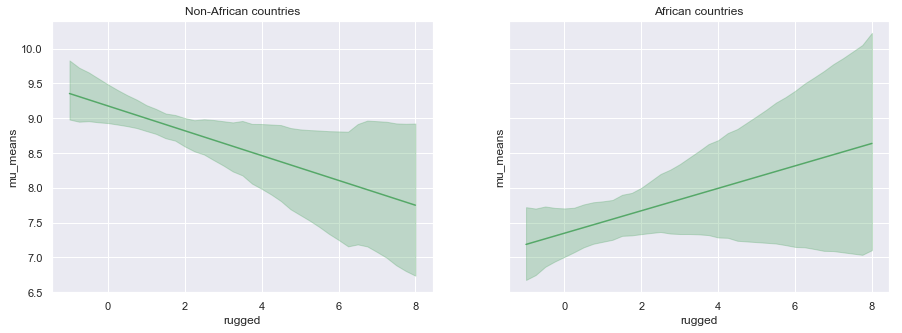

In [385]:
# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

In [389]:
pm.trace_to_dataframe(fit_m_7_5.trace).mean().filter(like='b')

bR    -0.184990
bA    -1.842532
bAR    0.349372
dtype: float64

### 7.1.4. Interpreting an interaction estimate